Root Insurance Optimal Bidding Strategy Analysis\
Robert Palmere, 2021\
Email: rdp135@chem.rutgers.edu

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import seaborn as sns
import math

print(sys.version)

3.9.1 | packaged by conda-forge | (default, Dec 21 2020, 22:06:14) 
[Clang 11.0.0 ]


In [2]:
df = pd.read_csv('Root_Insurance_data.csv')
df.head()

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
0,unknown,2,1,M,10.0,2,False,0
1,Y,3,1,M,10.0,5,False,0
2,Y,3,2,M,10.0,5,False,0
3,N,3,2,S,10.0,4,False,0
4,unknown,2,2,S,10.0,2,False,0


-----------
"A Near-Optimal Bidding Strategy for Real-Time Display Advertising Auctions" - Srinivas Tunuguntla and Paul Hoban, 2021, Journal of Marketing Research (DOI: https://doi.org/10.1177/0022243720968547)

Probability of conversion ${P_n(\beta)}$ (advertiser's valuation) is $v$ = $\frac{1}{1+e^{\beta_0+\beta_1R}}$ where $R$ is some normally distributed parameter we would acquire about our customer in real-time. This is a simplified model.

The first bid can then be computed as $b_1$ = $\frac{v_1}{\lambda_1}$. We arbitrarily set $\lambda_1$ = 1.0.

Since we don't have data regarding the bid prices of competitors we will assume that it is a gamma distribution which is correlated with our valuations.

Since b1 < w1, the incurred cost, $c$, is $c_1$ = $w_1$1($b_1$>$w_1$) which is just 0 unless we win the auction.

We update $\lambda$ using Eq. 8. : $\lambda_{n+1}$ - $\frac{1}{n}$$\sum_{i=1}^{n}\lambda_i$ = -$\frac{1}{\mu}$(${\rho}$ - $\frac{1}{n}$$\sum_{i=1}^{n}c_i$) where $\rho$ = $\frac{B}{N}$ which is the budget per auction.

Now we will write a class to perform the simulation. The goal is to obtain ${\lambda^*}$ for each category of customer.

In [3]:
class Simulation(object):
    ''' Class for simulating optimal bidding strategy
    '''
    
    def __init__(self, B, N, beta):
        '''
        
        Parameters
        ----------
        
        self.B : float
            Total budget for making bids
        
        self.N : int
            Total number of auctions
            
        self.lambda : float
            Lagrange multiplier in equation 4. Convergence of lambda is the objective.
            
        self.mu : float
            Recommended factor
            
        self.b : float
            Bid being placed by advertiser b = v/w
            
        self.c : float
            Cost incurred
            
        self.rho : float
            Budget per auction
            
        self.vs : list
            Recorded valuations
            
        '''
        
        self.B = B
        self.beta = beta
        self.N = N
        self.L = 1
        self.mu = 1
        self.rho = self.B/self.N
        self.lambdas = []
        self.bs = []
        self.cs = []
        self.ws = []        
        self.vs = []
        
    def compute_valuation(self):
        b0 = -1
        b1 = self.beta
        R = round(np.random.normal(0)) # Truncated normal distribution sampling
        v = lambda R : (1) / (1+np.exp(-b0+b1*R)) # just depends on Optimal Rank for Now
        return v(R)
        
    def compute_lambda(self):
        next_lambda = (np.average(self.lambdas)) - ((1/self.mu) * (self.rho - np.average(self.cs)))
        return next_lambda
        
    def run(self):
        for step in range(self.N):
            v = self.compute_valuation()*20 # Assuming valuation average is not 0.5 but rather $10 (*20)
            b = (v/self.L)
            self.bs.append(b)
            self.lambdas.append(self.L)
            w = np.random.gamma(2.75, v)
            print('Valuation: %f | Lambda: %f | Bid: %f | Competitor Bid: %f' % (v, self.L, b, w), end='\r')
            self.ws.append(w)
            if b > w:
                self.cs.append(b)
            elif b < w:
                self.cs.append(0)
            lam = self.compute_lambda()
            self.L = lam
    

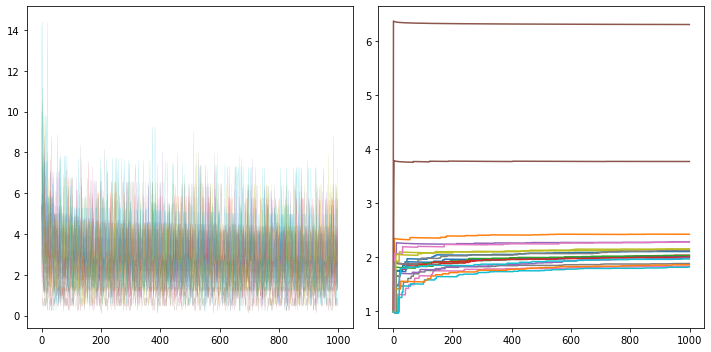

In [4]:
# Run simulation for a series of beta coefficients of R

sims = [Simulation(10, 1000, i) for i in np.arange(0, 1, .05)]

fig, ax = plt.subplots(1, 2, figsize=(10,5))

converged_lambdas = []
successes = []
for s in sims:
    s.run()
    ax[0].plot(s.bs, lw=0.1)
    ax[1].plot(s.lambdas)
    successes.append(len([i for i in s.cs if i != 0]))
    converged_lambdas.append(max(s.lambdas))
plt.tight_layout()


Without solving directly for ${\beta_1}$, we see convergence of all ${\lambda}$s to their respective ${\lambda^{*}}$. The optimal bid is ${b_n}$ = $\frac{v_n}{\lambda^*}$  (Eq. 6 in paper). With our current valuation at a constant ${$10}$, we can calculate an improved constant bid price by calculating $\frac{10}{~\lambda^{*}}$.

In [5]:
# Skipping gradient descent for finding beta coefficient of R in our logit function, we simply take the minimum of converged lambdas.

est_lambda_star = min(converged_lambdas) # Estimated Lambda star value
print(est_lambda_star)

1.8189053846918488


In [6]:
# Improved constant bid price

const_bid = 10/est_lambda_star

print(const_bid)

5.497812082014457
